<a href="https://colab.research.google.com/github/baskayj/Boundary-behaviour-in-stochastic-differential-equations-used-in-Finance/blob/master/CIR_Boundary_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boundary behaviour in stochastic differential equations used in Finance

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import multiprocessing as mp
import pandas as pd

from collections import namedtuple
from google.colab import drive
from datetime import datetime

In [0]:
#To load and save simulation data

drive.mount('/content/gdrive')
DATA_PATH = '/content/gdrive/My Drive/MSc. Szakdolgozat/Data/'

KeyboardInterrupt: ignored

In [0]:
font = {'size'   : 18}
plt.rc('font', **font)

In [0]:
#CIR MODEL
#There are multiple finite-diffrence schemes for simulation including,
#Euler-Maryama Scheme: X[i] = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
#Weighted Milstein Scheme: X[i] = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
#Non-central chi^2 method which means taking values for the expected distribution.

#gamma = 2*kappa*theta/sigma^2

#-------------------------------------------------------------------------------
def CIR_prcss(X0, dt, T, kappa, theta, sigma, seed, **kwargs):
  if kwargs.get('WMS'):
  #Weighted Milstein Scheme

    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X[N-1]

#-------------------------------------------------------------------------------  
  elif kwargs.get('Exact'):
  #Exact Scheme (Non-central chi^2 method)
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        X[i] = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
        if x < dt :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        X[i] = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
      return X[N-1]

#-------------------------------------------------------------------------------
  else:
  #Euler-Maryama Scheme
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X[N-1]

In [0]:
# CLASS for MP

class CIR():
  def __init__(self,X0,dt,T,kappa,theta,sigma):
    self.X0 = X0
    self.dt = dt
    self.T = T
    self.kappa = kappa
    self.theta = theta
    self.sigma = sigma

  def Prcss_WMS_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Path = True)
  def Prcss_WMS_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Barrier = True)
  def Prcss_WMS(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True)

  def Prcss_Exact_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True, Path = True)
  def Prcss_Exact_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True, Barrier = True)
  def Prcss_Exact(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True)

  def Prcss_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Path = True)
  def Prcss_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Barrier = True)
  def Prcss(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed)

In [0]:
#MULTIPROCESS FUNCTION

def CIR_Prcss_mp(X0,dt,T,kappa,theta,sigma,**kwargs):
  cir = CIR(X0,dt,T,kappa,theta,sigma)
  pool = mp.Pool(processes=mp.cpu_count())
  if kwargs.get('WMS'):
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_WMS_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_WMS_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss_WMS,range(mc_rep))
      pool.close()
      return R
  elif kwargs.get('Exact'):
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_Exact_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_Exact_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss_Exact,range(mc_rep))
      pool.close()
      return R
  else:
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss,range(mc_rep))
      pool.close()
      return R

In [0]:
# MISC. FUNCTIONS

def print_log(string):
  logs = open(f"{DATA_PATH}logs.txt","a")
  logs.write(string)
  logs.close()

def sort(R):
  c0 = 0
  cm = 0
  cT = 0

  for rr in R:
    if rr == -1:
      c0 += 1
    elif rr == 1:
      cm += 1
    else:
      cT += 1
  
  res = [c0/mc_rep,cm/mc_rep,cT/mc_rep]
  return res

def Richardson(c0,h,n):
  R = []
  for i in range(len(c0)-1):
    t = (h[i+1]-h[i])/h[i]
    r = (np.power(t,n)*c0[i+1]-c0[i])/(np.power(t,n)-1)
    R.append(r)
  return min(R)

---
---

## 1.) Runtime Comparison

In [0]:
#Number of generated trajectories
mc_rep = 10

### As a function of $\gamma$

In [0]:
model = 'CIR_'
name = 'Runtime_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_euler = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_euler.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Euler.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.2843654155731201 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.28810572624206543 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.29432201385498047 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.27999353408813477 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.28906702995300293 seconds.[5/10]

Making trajectories for X

In [0]:
model = 'CIR_'
name = 'Runtime_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_WMS = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_WMS.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.650902509689331 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.6319222450256348 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.6239502429962158 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.6276462078094482 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.6277470588684082 seconds.[5/10]

Making trajectories for X0 = 0.5

In [0]:
model = 'CIR_'
name = 'Runtime_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_Exact = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_Exact.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.5049934387207031 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.49833059310913086 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.48824405670166016 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.499176025390625 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.4936964511871338 seconds.[5/10]

Making trajectories for X0 =

In [0]:
#Calculating the relative increase in runtime
for i in range(len(t_WMS)):
  t_WMS[i] = ((t_WMS[i]/t_euler[i])-1)*100

for i in range(len(t_Exact)):
  t_Exact[i] = ((t_Exact[i]/t_euler[i])-1)*100

#### Results

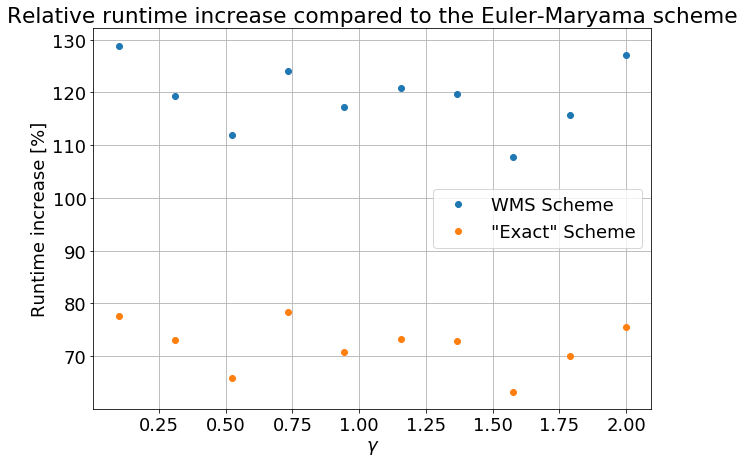

In [0]:
gammas = np.linspace(0.1,2,10)

plt.figure(figsize=(10,7))
plt.plot(gammas,t_WMS,"o", label = "WMS Scheme")
plt.plot(gammas,t_Exact,"o", label = "\"Exact\" Scheme")

plt.title("Relative runtime increase compared to the Euler-Maryama scheme")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("Runtime increase [%]")
plt.grid()

---

### As a function of $dt$

In [0]:
model = 'CIR_'
name = 'Runtime_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_euler = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_euler.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Euler.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.026070117950439453 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.02857041358947754 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.029428720474243164 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.04375863075256348 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.03524160385131836 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1

In [0]:
model = 'CIR_'
name = 'Runtime_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_WMS = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_WMS.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.028271198272705078 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.024410486221313477 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.028476953506469727 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.03231382369995117 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.04935884475708008 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,

In [0]:
model = 'CIR_'
name = 'Runtime_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_Exact = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_Exact.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.03172421455383301 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.027401208877563477 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.0321502685546875 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.03671908378601074 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.046651601791381836 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,

In [0]:
#Calculating the relative increase in runtime
for i in range(len(t_WMS)):
  t_WMS[i] = ((t_WMS[i]/t_euler[i])-1)*100

for i in range(len(t_Exact)):
  t_Exact[i] = ((t_Exact[i]/t_euler[i])-1)*100

#### Results

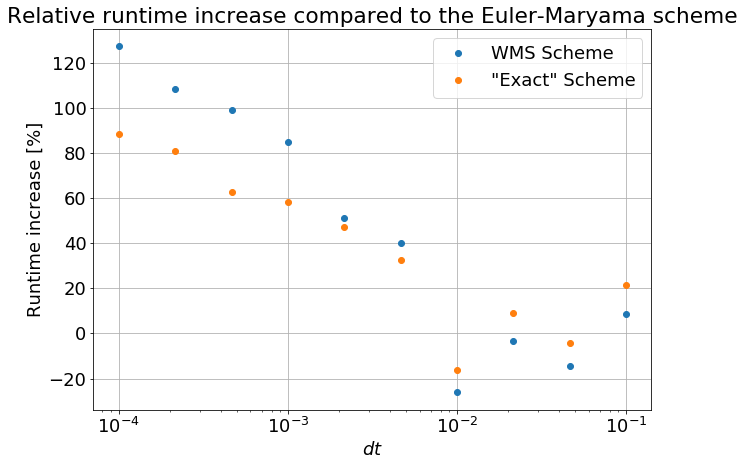

In [0]:
dts = np.logspace(np.log10(0.1),np.log10(0.0001),10)

plt.figure(figsize=(10,7))
plt.plot(dts,t_WMS,"o", label = "WMS Scheme")
plt.plot(dts,t_Exact,"o", label = "\"Exact\" Scheme")

plt.title("Relative runtime increase compared to the Euler-Maryama scheme")
plt.legend()
plt.xlabel("$dt$")
plt.ylabel("Runtime increase [%]")
plt.xscale("log")
plt.grid()

---
---

## 2.) Evaluating the accuracy of the simulations using two sample Kolmogorov-Smirnov test

In [0]:
from scipy.stats import ks_2samp

In [0]:
#Number of generated trajectories
mc_rep = 1000

### As a function of $\gamma$

In [0]:
model = 'CIR_'
name = 'Ktest_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")

Y = X



Staring Experiment CIR_Ktest_Exact.

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.5091283321380615 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.5076026916503906 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.5130429267883301 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.49643778800964355 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.4897572994232178 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.

In [0]:
model = 'CIR_'
name = 'Ktest_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_Euler.

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.2865736484527588 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.2921268939971924 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.28557300567626953 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.28658008575439453 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.2972550392150879 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0

In [0]:
pval_Euler = []
for i in range(len(Y)):
  pval_Euler.append(list(ks_2samp(X[i],Y[i]))[1])

In [0]:
model = 'CIR_'
name = 'Ktest_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_WMS.

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.614577054977417 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.6234269142150879 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.6270110607147217 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.6356778144836426 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.6151046752929688 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.01,T

In [0]:
pval_WMS = []
for i in range(len(Y)):
  pval_WMS.append(list(ks_2samp(X[i],Y[i]))[1])

del X
del Y

#### Results

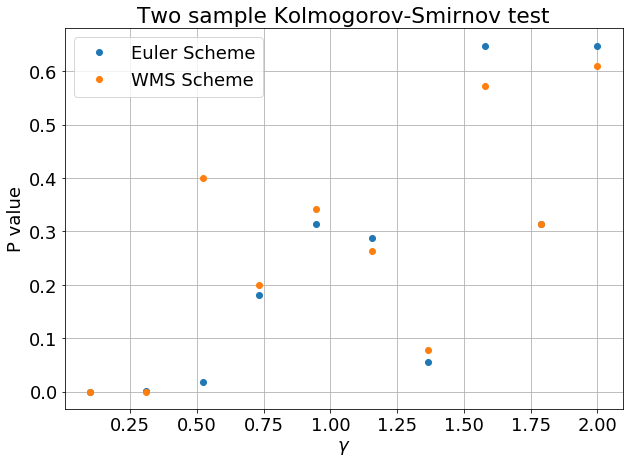

In [0]:
gammas = np.linspace(0.1,2,10)

plt.figure(figsize=(10,7))
plt.plot(gammas,pval_Euler,"o", label = "Euler Scheme")
plt.plot(gammas,pval_WMS,"o", label = "WMS Scheme")

plt.title("Two sample Kolmogorov-Smirnov test")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("P value")
plt.grid()

---

### As a function of $dt$

In [0]:
model = 'CIR_'
name = 'Ktest_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")

Y = X



Staring Experiment CIR_Ktest_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.09897470474243164 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.1654655933380127 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.30064892768859863 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.5963940620422363 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.239091157913208 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa =

In [0]:
model = 'CIR_'
name = 'Ktest_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_Euler.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.07203459739685059 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.09960699081420898 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.1699981689453125 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.31513452529907227 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.6152985095977783 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa

In [0]:
pval_Euler = []
for i in range(len(Y)):
  pval_Euler.append(list(ks_2samp(X[i],Y[i]))[1])

In [0]:
model = 'CIR_'
name = 'Ktest_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_WMS.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.11161184310913086 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.19121980667114258 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.3724243640899658 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.7567970752716064 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.5304958820343018 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 

In [0]:
pval_WMS = []
for i in range(len(Y)):
  pval_WMS.append(list(ks_2samp(X[i],Y[i]))[1])

del X
del Y

#### Results

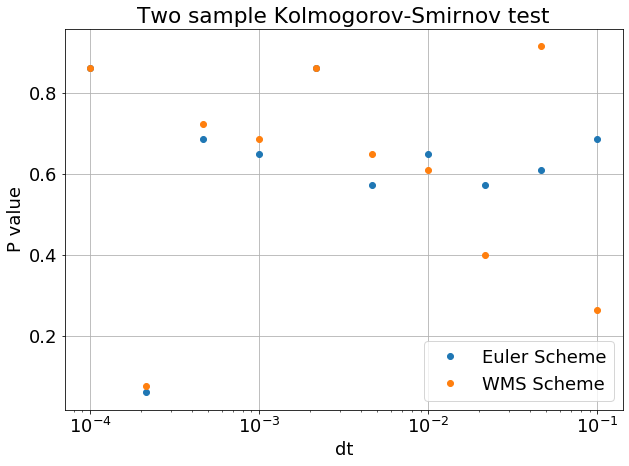

In [0]:
gammas = np.logspace(np.log10(0.1),np.log10(0.0001),10)

plt.figure(figsize=(10,7))
plt.plot(gammas,pval_Euler,"o", label = "Euler Scheme")
plt.plot(gammas,pval_WMS,"o", label = "WMS Scheme")

plt.title("Two sample Kolmogorov-Smirnov test")
plt.legend()
plt.xlabel("dt")
plt.ylabel("P value")
plt.xscale("log")
plt.grid()

---
---

## 3.) Measuring the time to cross the barriers
Lower barrier: $0$

Upper barrier $2 X_0$

In [0]:
#Number of generated trajectories
mc_rep = 1000

In [0]:
model = 'CIR_'
name = 'full_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 2,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = [0.1,3]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True", Path = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_full_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 2,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 1 minutes and 36.946229696273804 seconds.[1/2]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 2,kappa = 1,theta = 1,sigma = 0.816496580927726.

  Finished generating trajectories in 1 minutes and 33.54408621788025 seconds.[2/2]

The experiment finished in 3 minutes and 10.53278636932373 seconds.



In [0]:
#X[0] ---> under gammac
#X[1] ---> above gammac

In [0]:
tau0s_u = []
tau2X0s_u = []

for i in range(len(X[0])):
  tau0 = 1
  tau2X0 = 1
  t = 0
  for j in range(len(X[0][i])):
    if (X[0][i][j] < 0.0001) & (t <= tau0):
      tau0 = t
    elif (X[0][i][j] >= 1) & (t <= tau2X0):
      tau2X0 = t
    t += 0.0001
  if tau0 > tau2X0:
    tau2X0s_u.append(tau2X0)
  else:
    tau0s_u.append(tau0)

In [0]:
tau0s_a = []
tau2X0s_a = []

for i in range(len(X[1])):
  tau0 = 1
  tau2X0 = 1
  t = 0
  for j in range(len(X[1][i])):
    if (X[1][i][j] < 0.0001) & (t <= tau0):
      tau0 = t
    elif (X[1][i][j] >= 1) & (t <= tau2X0):
      tau2X0 = t
    t += 0.0001
  if tau0 > tau2X0:
    tau2X0s_a.append(tau2X0)
  else:
    tau0s_a.append(tau0)

### Results

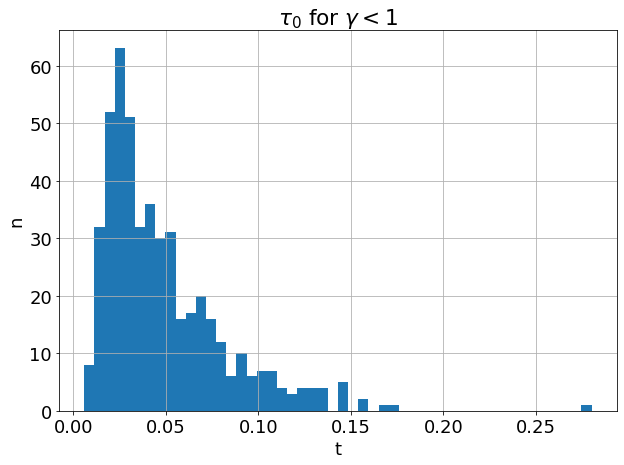

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau0s_u,bins = 50)

plt.title("$\\tau_0$ for $\gamma < 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

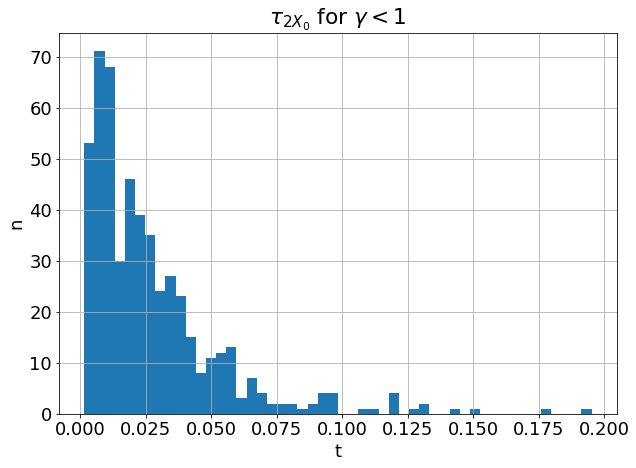

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau2X0s_u, bins = 50)

plt.title("$\\tau_{2X_0}$ for $\gamma < 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

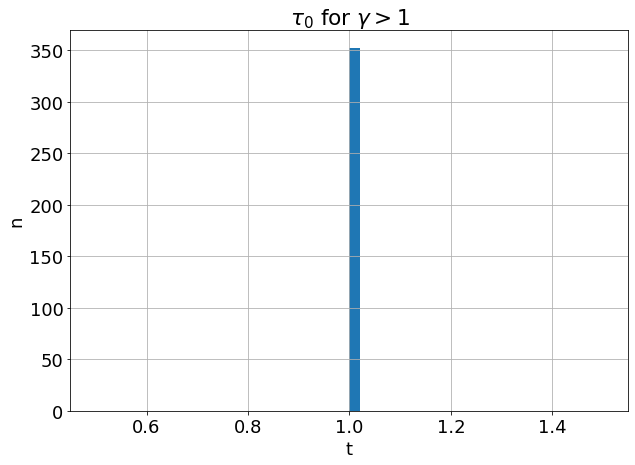

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau0s_a, bins = 50)

plt.title("$\\tau_0$ for $\gamma > 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

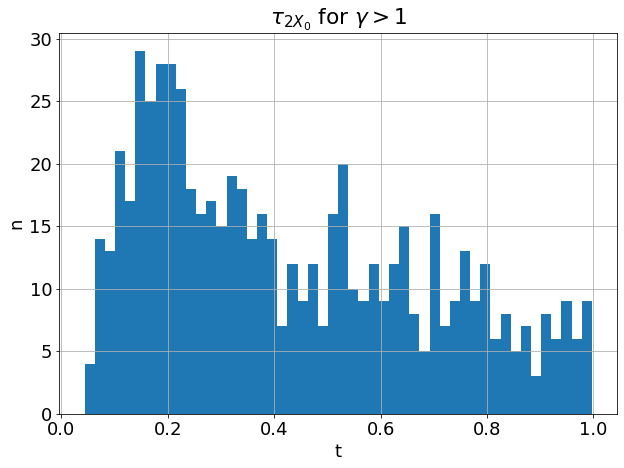

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau2X0s_a, bins = 50)

plt.title("$\\tau_{2X_0}$ for $\gamma > 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

---
---

## 4.) Findig $\gamma_c$ numerically

In [0]:
#Number of generated trajectories
mc_rep = 1000

In [0]:
model = 'CIR_'
name = 'Barrier_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,20)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

var2_name = "dt"
var2 = np.logspace(np.log10(0.1),np.log10(0.00001),20)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  for j in range(len(var2)):
    T.append([P.X0,var2[j],P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X.append(sort(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True", Barrier = "True")))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Barrier_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.055769920349121094 seconds.[1/400]

Making trajectories for X0 = 0.5,dt = 0.06158482110660264,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.0626077651977539 seconds.[2/400]

Making trajectories for X0 = 0.5,dt = 0.0379269019073225,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.06988811492919922 seconds.[3/400]

Making trajectories for X0 = 0.5,dt = 0.023357214690901226,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.0660099983215332 seconds.[4/400]

Making trajectories for X0 = 0.5,dt = 0.01438449888287663,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.07749795913

In [0]:
P = np.zeros((len(var),len(var2)))

for i in range(len(var)):
  for j in range(len(var2)):
    P[i,j] = X[i*len(var2) + j][0]

P_lim = []
for i in range(len(var)):
  P_lim.append(Richardson(P[i,:],np.log10(var2),5))

### Results

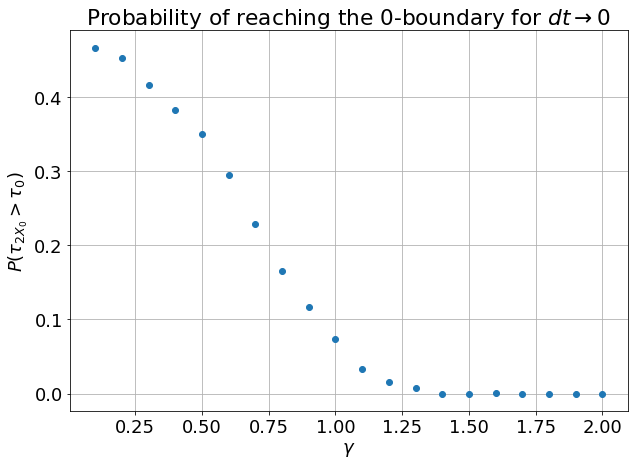

In [0]:
plt.figure(figsize=(10,7))
plt.plot(var,P_lim,"o")

plt.title("Probability of reaching the 0-boundary for $dt \\rightarrow 0$ ")

plt.xlabel("$\gamma$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()

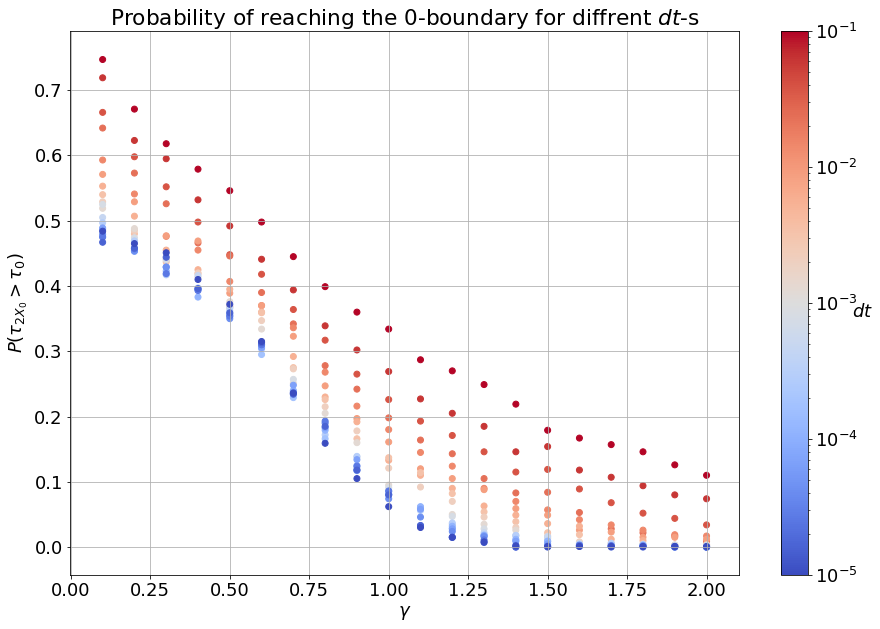

In [0]:
dt = np.zeros((20,20))
for i in range(0,20):
  for j in range(0,20):
    dt[i,j] = var2[i]

plt.figure(figsize=(15,10))
for i in range(20):
  plt.scatter(var,P[:,i],c = dt[i], norm=colors.LogNorm(vmin=dt.min(),vmax=dt.max()), cmap = "coolwarm")

cbar = plt.colorbar()
cbar.set_label("$dt$", rotation = 0)

plt.title("Probability of reaching the 0-boundary for diffrent $dt$-s")
plt.xlabel("$\gamma$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()

---
---

## Appendix

### A.) Relationship between the CIR-Process and the Noncentral $\chi ^2$-distribution

A noncentral $\chi^2$-distribution can be described with the probability density function:
$$f_\chi (x,k,\lambda) = \sum_{x = 0}^{\infty}{\frac{e^{-\lambda/2}(\lambda/2)^i}{i!}f_{Y_k+2i}(x)}$$
Where $Y_q$ is $\chi^2$ distributed with degrees of freedom of $q$.
The parameters of this thistribution:
* $k$ degrees of freedom
* $\lambda$ noncentrality parameter

According to [2] the CIR process can be simulated by setting the degrees of freedom and non-centrality parameters as follows:
* $k := \frac{4\kappa\theta}{\sigma^2} = 2\gamma$
* $\lambda := X_{t_n}\eta(dt)$
Where we introduced the function $\eta(dt)$ as 
$$ \eta(dt) := \frac{4\kappa}{\sigma^2} e^{-\kappa dt} (1-e^{-\kappa dt})$$

With this the $t_{n+1}$-th step looks like:
$$ X_{t_{n+1}} = \chi^2_k (\lambda) \frac{e^{-\kappa dt}}{\eta(dt)} $$

We can use **numpy.random.noncentral_chisquare** to draw random numbers from the noncentral $\chi^2$-distribution.


References:

[1] https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution

[2] https://arxiv.org/pdf/0802.4411.pdf

---

### B.) CIR as a squared Ornstein-Uhlenbeck process

Starting from
$$ dX_t = \kappa (\theta -X_t)dt + \sigma \sqrt{X_t}dW_t $$
We can introduce
$$ Y_t(X_t) := \sqrt{X_t} $$
Ito's lemma states that if $X_t$ follows the SDE
$$ dX_t = \mu_t dt + \sigma_t dW_t$$
Then the function $Y_t(X_t)$ follows the following SDE:
$$ dY_t = \left( \frac{\partial Y_t}{\partial t} + \mu_t \frac{\partial Y_t}{\partial x} + \frac{\sigma_t^2}{2}\frac{\partial Y_t^2}{\partial^2 x} \right) dt +  \sigma_t \frac{\partial Y_t}{\partial x} dW_t $$

In the case of the CIR-process with $Y_t$ introduced earlier this SDE will be
$$
dY_t = \left[\left(\frac{\kappa\theta}{2}-\frac{\sigma^2}{8}\right)\frac{1}{Y_t} - \frac{\kappa}{2}Y_t\right]dt + \frac{\sigma}{2}dW_t
$$
In the special case of $\frac{\kappa\theta}{2}-\frac{\sigma^2}{8} = 0$, which in therms of $\gamma$  means $\gamma = 0.5$ will result in
$$
dY_t =  - \frac{\kappa}{2}Y_tdt + \frac{\sigma}{2}dW_t
$$
Which is an Ornstein-Uhlenbeck-type SDE.

This has a known solution:
$$
Y_t = Y_0e^{-\frac{\kappa}{2}t} + \frac{\sigma}{2}\int_{0}^{t}{e^{-\frac{\kappa}{2}(t-t')}dW_{t'}}
$$
Furthermore the PDF is also known:
$$
f(Y,t) = \sqrt{\frac{\kappa}{8\pi\sigma^2(1-e^{-\kappa(t-t_0)})}} exp\left[-\frac{\kappa}{8\sigma^2} \frac{(Y-Y_0e^{-\frac{\kappa}{2}(t-t_0)})^2}{1-e^{-{\kappa}(t-t_0)}}\right]
$$
We can transform this back using
$$
f_X(x) = f_Y(g^{-1}(x))\left|\frac{d}{dx} g^{-1}(x)\right|
$$
With $X = Y^2 \rightarrow g^{-1}(x) = \sqrt{x} \rightarrow \frac{d}{dx} g^{-1}(x)= \frac{1}{2} \frac{1}{\sqrt{x}}$

Substituting it into the transformation rule the PDF for $X_t$ given $X_0$ and $t_0$ will be
$$
f(X,t) = \sqrt{\frac{\kappa}{32\pi\sigma^2(1-e^{-\kappa(t-t_0)})}} \frac{1}{\sqrt{X}}exp\left[-\frac{\kappa}{8\sigma^2} \frac{\left(\sqrt{X}-\sqrt{X_0}e^{-\frac{\kappa}{2}(t-t_0)}\right)^2}{1-e^{-{\kappa}(t-t_0)}}\right]
$$